In [609]:
## The treshold adjusting 

In [610]:
# upper bound for gini 0.9
#inability_target max 0.5

In [620]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

class WealthAgent(Agent):
    def __init__(self, unique_id, model, disposable_income, dwelling, technology, inability=False):
        super().__init__(unique_id, model)
        self.disposable_income = disposable_income
        self.dwelling = dwelling
        self.technology = technology
        self.inability = inability
        self.wealth = disposable_income


    def check_inability(self, threshold=0.1):
        """Check if the energy cost exceeds the threshold of the disposable income."""
        energy_cost = self.energy_cost
        print(f"Income: {self.disposable_income}, Threshold: {threshold}, Energy cost: {energy_cost}")
        if self.disposable_income * threshold < energy_cost:
            self.inability = True
        else:
            self.inability = False
        print(f"Inability: {self.inability}")



    @property
    def energy_cost(self):
        """Calculate and return the current energy cost for the agent."""
        return self.model.energy_price * (self.dwelling + self.technology)

    def step(self):
        """The agent does not have any behavior in a step."""
        self.wealth = self.disposable_income - self.energy_cost
        self.check_inability()


class WealthModel(Model):
    
    @classmethod
    def calculate_gini(cls, incomes):
        incomes = np.sort(incomes)
        n = len(incomes)
        index = np.arange(1, n + 1)
        return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

    @classmethod
    def generate_income_distribution(cls, num_people, median_income, gini_target, lower_bound):
        alpha = (gini_target + 1) / (2 - gini_target)
        for _ in range(10000):
            incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)
            incomes = np.clip(incomes, lower_bound, None)  # None means there is no upper bound
            gini_current = cls.calculate_gini(incomes)
            if np.isclose(gini_current, gini_target, atol=0.01):
                return incomes
            elif gini_current < gini_target:
                alpha *= 0.9
            else:
                alpha *= 1.1

        raise Exception(f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}")

    # def assign_inability_and_dwelling_technology(self, incomes, inability_target):
    #     total_inability = int(inability_target * self.num_agents)

    #     dwellings = np.zeros(self.num_agents)
    #     technologies = np.zeros(self.num_agents)
    #     inability = np.zeros(self.num_agents, dtype=bool)

    #     # Select agents with inability
    #     inability_agents = np.random.choice(self.num_agents, total_inability, replace=False)
    #     for idx in inability_agents:
    #         inability[idx] = True
    #         # Assign dwelling and technology to make the combined energy cost more than 10% of income
    #         while self.energy_price * (dwellings[idx] + technologies[idx]) <= 0.1 * incomes[idx]:
    #             dwellings[idx] = np.random.randint(500, 1800)
    #             technologies[idx] = np.random.randint(200, 600)

    #     for idx in range(self.num_agents):
    #         if not inability[idx]:
    #             # Assign dwelling and technology to make the combined energy cost less than 10% of income
    #             while self.energy_price * (dwellings[idx] + technologies[idx]) >= 0.1 * incomes[idx]:
    #                 dwellings[idx] = np.random.randint(500, 1000)
    #                 technologies[idx] = np.random.randint(200, 500)

    #     return dwellings, technologies, inability




def assign_inability_and_dwelling_technology(self, incomes, inability_target):
    sorted_incomes = np.sort(incomes)
    income_quartiles = np.array_split(sorted_incomes, 4)

    total_inability = int(inability_target * self.num_agents)
    inability_per_quartile = [0.5, 0.2, 0.1, 0.2]  # inability target distribution among quartiles

    inability = np.zeros(self.num_agents, dtype=bool)

    idx = 0  # Counter for agents across all quartiles
    for quartile, incomes in enumerate(income_quartiles):
        inability_for_this_quartile = int(total_inability * inability_per_quartile[quartile])
        inability_agents = np.random.choice(len(incomes), inability_for_this_quartile, replace=False)
        for i in range(len(incomes)):
            if i in inability_agents:
                inability[idx] = True
            idx += 1

    return inability


    def energy_price_x(self):
        return self.energy_prices[0]

    def energy_price_y(self):
        return self.energy_prices[1]




    def __init__(self, N, median_income, min_disposal, gini_target, energy_prices:[],energy_shares:[], inability_target, growth_boundaries:[]):
        self.num_agents = N
        self.median_income = median_income
        self.min_disposal = min_disposal
        self.gini_target = gini_target
        self.energy_prices = energy_prices
        self.energy_shares = energy_shares
        self.inability_target = inability_target
        self.growth_boundaries = growth_boundaries
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            agent_reporters={"Dwelling": "dwelling", 
                             "Technology": "technology", 
                             "Income": "disposable_income",
                             "Inability": "inability",
                             "Wealth":"wealth",
                             "EnergyCost": "energy_cost"},
            model_reporters = {
                            "Inability Over Time": lambda model: sum(agent.inability for agent in model.schedule.agents) / model.num_agents,
                            "Energy Price": lambda model: model.energy_price,
                            "Energy Price X": lambda model: model.energy_prices[0],
                            "Energy Price Y": lambda model: model.energy_prices[1]
            })

        # Generate disposable incomes and assign dwelling and technology
        incomes = self.generate_income_distribution(self.num_agents, self.median_income, self.gini_target, self.min_disposal)
        dwellings, technologies, inability = self.assign_inability_and_dwelling_technology(incomes, self.inability_target)


        # Create agents
        for i in range(self.num_agents):
            a = WealthAgent(i, self, disposable_income=incomes[i], dwelling=dwellings[i], technology=technologies[i], inability=inability[i])
            self.schedule.add(a)

    def update_energy_prices(self):
        for i in range(len(self.energy_prices)):
            growth_rate = np.random.uniform(*self.growth_boundaries[i])
            self.energy_prices[i] *= 1 + growth_rate


    @property
    def energy_price(self):
        """Calculate and return the current energy price in the model."""
        return self.energy_prices[0] * self.energy_shares[0] + self.energy_prices[1] * self.energy_shares[1]

    def step(self):
        """Advance the model by one step."""
        self.update_energy_prices()
        self.datacollector.collect(self)  # Collect data before updating the prices
        self.schedule.step()

In [621]:

model = WealthModel(100, 2000, 500, 0.25, [0.8,0.8],[0.5,0.5], 0.15, [[0,0 ], [0, 0]])

for i in range(100):
    model.step()

In [622]:
agent_data.head(100)['Inability'].sum()/ 100

0.15

In [623]:
agent_data[agent_data["Step"] == 0]["Income"]

0     2533.303693
1     1218.235493
2     1961.368505
3     2220.761847
4     1554.122027
         ...     
95    2666.257058
96    1957.969924
97    2850.723076
98    2206.804930
99    1550.298064
Name: Income, Length: 100, dtype: float64

In [624]:
100 * 0.15

15.0

In [616]:
15*0.3

4.5

In [617]:
agent_data

,Step,AgentID,Dwelling,Technology,Income,Inability,Wealth,EnergyCost,IncomeQuartile
0,0,0,0.0,0.0,2533.303693,False,2533.303693,0.0,3
1,0,1,0.0,0.0,1218.235493,False,1218.235493,0.0,0
2,0,2,0.0,0.0,1961.368505,False,1961.368505,0.0,2
3,0,3,0.0,0.0,2220.761847,False,2220.761847,0.0,2
4,0,4,0.0,0.0,1554.122027,False,1554.122027,0.0,1
...,...,...,...,...,...,...,...,...,...
995,9,95,0.0,0.0,2666.257058,True,2666.257058,0.0,3
996,9,96,0.0,0.0,1957.969924,True,1957.969924,0.0,2
997,9,97,0.0,0.0,2850.723076,True,2850.723076,0.0,3
998,9,98,0.0,0.0,2206.804930,True,2206.804930,0.0,2


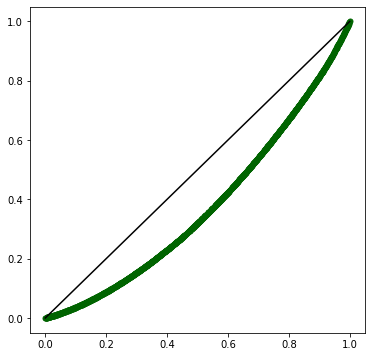

In [618]:
def plot_lorenz_curve(X, yummy_figs = (6, 6)):

    X_sorted = np.sort(X)  # Sort the incomes
    lorenz = np.cumsum(X_sorted) / np.sum(X_sorted)
    lorenz = np.insert(lorenz, 0, 0)
    lorenz[0], lorenz[-1]

    fig, ax = plt.subplots(figsize=[yummy_figs[0],yummy_figs[1]])
    ax.scatter(np.arange(lorenz.size)/(lorenz.size-1), lorenz, 
            marker='.', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')

plot_lorenz_curve(agent_data["Income"])

In [619]:
# Before plotting, convert the collected data to a pandas DataFrame
model_data = model.datacollector.get_model_vars_dataframe()

# Plot the energy prices over time
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(model_data['Energy Price'], label='Combined Energy Price')
plt.plot(model_data['Energy Price X'], label='Energy Price X')
plt.plot(model_data['Energy Price Y'], label='Energy Price Y')
plt.title('Energy Prices Over Time')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()


AttributeError: 'WealthModel' object has no attribute 'datacollector'

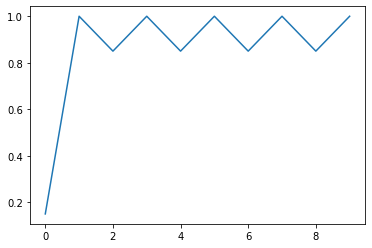

In [ ]:
plt.plot(model_data['Inability Over Time'])

In [ ]:
model_data['Inability Over Time']

0    0.15
1    0.85
2    0.85
3    0.85
4    0.85
5    0.85
6    0.85
7    0.85
8    0.85
9    0.85
Name: Inability Over Time, dtype: float64

In [ ]:
agent_data

,Step,AgentID,Dwelling,Technology,Income,Inability,Wealth,EnergyCost,IncomeQuartile
0,0,0,0.0,0.0,2445.963194,False,2445.963194,0.000000,2
1,0,1,0.0,0.0,1360.800570,False,1360.800570,0.000000,1
2,0,2,0.0,0.0,4349.614616,False,4349.614616,0.000000,3
3,0,3,0.0,0.0,775.463311,False,775.463311,0.000000,0
4,0,4,0.0,0.0,1951.375750,False,1951.375750,0.000000,2
...,...,...,...,...,...,...,...,...,...
995,9,95,960.0,443.0,1188.304836,False,-11.897444,1209.187112,0
996,9,96,0.0,0.0,762.998367,True,762.998367,0.000000,0
997,9,97,503.0,546.0,532.112321,False,-365.259163,904.089295,0
998,9,98,1343.0,557.0,1564.454696,False,-60.908335,1637.530658,1


In [ ]:
agent_data.columns

Index(['Step', 'AgentID', 'Dwelling', 'Technology', 'Income', 'Inability',
       'Wealth', 'EnergyCost', 'IncomeQuartile'],
      dtype='object')

In [ ]:
import matplotlib.pyplot as plt

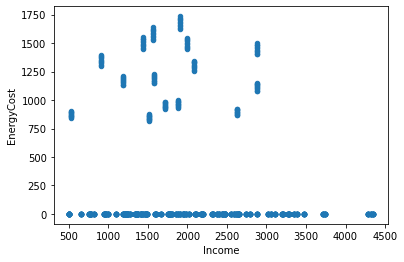

In [ ]:
agent_data.reset_index().plot(kind='scatter', x='Income', y='EnergyCost')
plt.show()

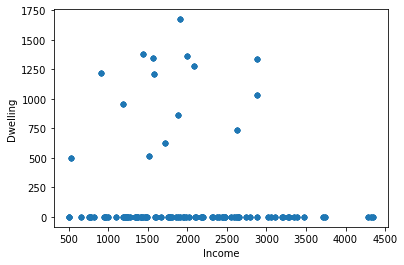

In [ ]:
agent_data.reset_index().plot(kind='scatter', x='Income', y='Dwelling')
plt.show()

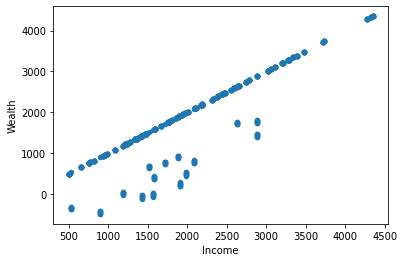

In [ ]:
agent_data.reset_index().plot(kind='scatter', x='Income', y='Wealth')
plt.show()

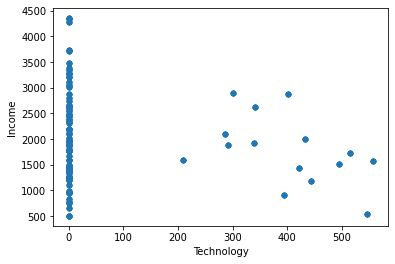

In [ ]:
agent_data.reset_index().plot(kind='scatter', x='Technology', y='Income')
plt.show()

In [ ]:
import pandas as pd

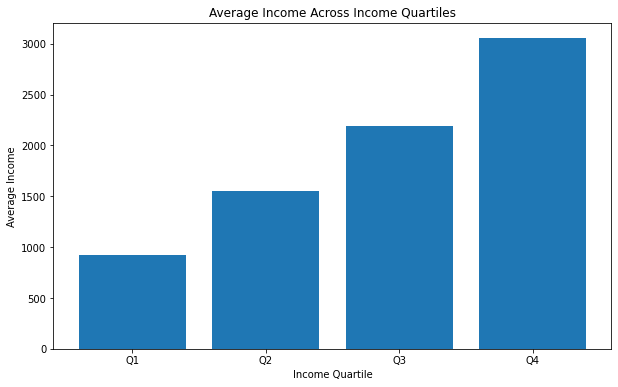

In [ ]:
agent_data = model.datacollector.get_agent_vars_dataframe().reset_index()
agent_data['IncomeQuartile'] = pd.qcut(agent_data['Income'], 4, labels=False)

grouped = agent_data.groupby('IncomeQuartile').mean()  # get mean for each group

plt.figure(figsize=(10, 6))
plt.bar(['Q1', 'Q2', 'Q3', 'Q4'], grouped['Income'])
plt.title('Average Income Across Income Quartiles')
plt.xlabel('Income Quartile')
plt.ylabel('Average Income')
plt.show()


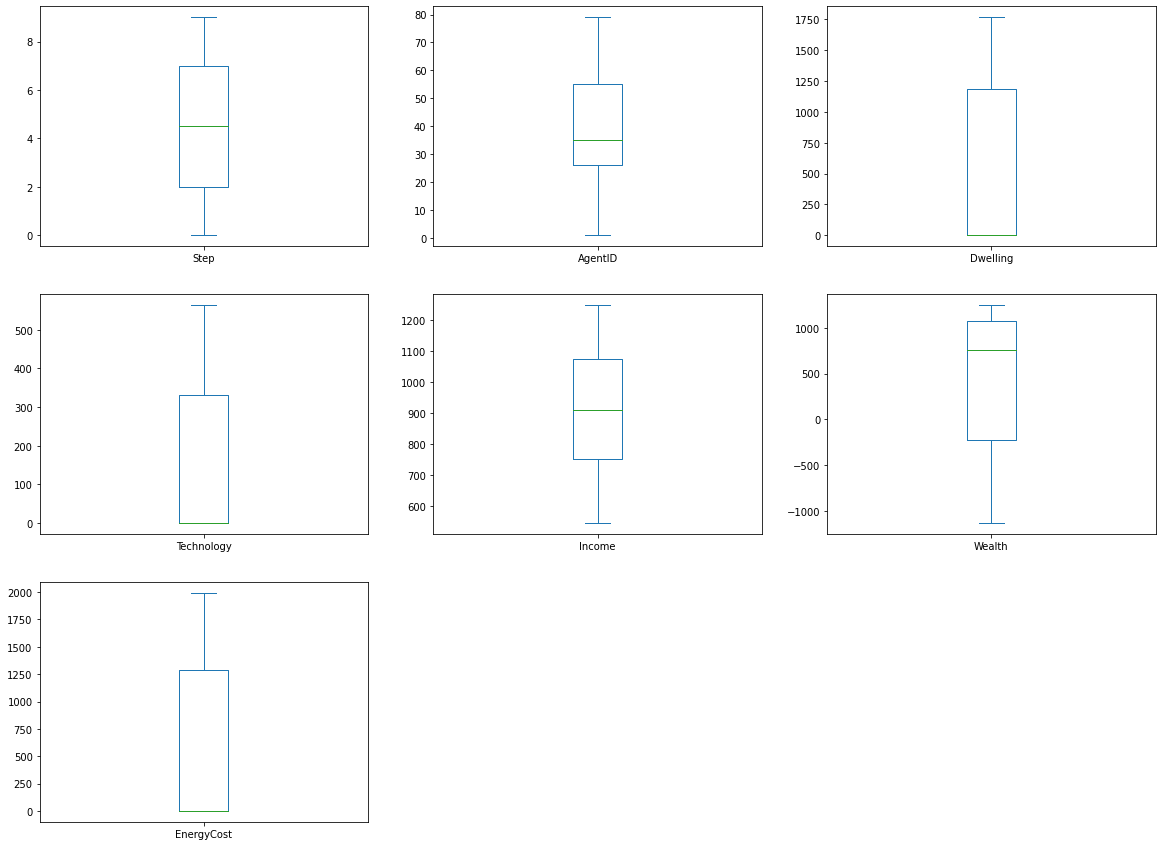

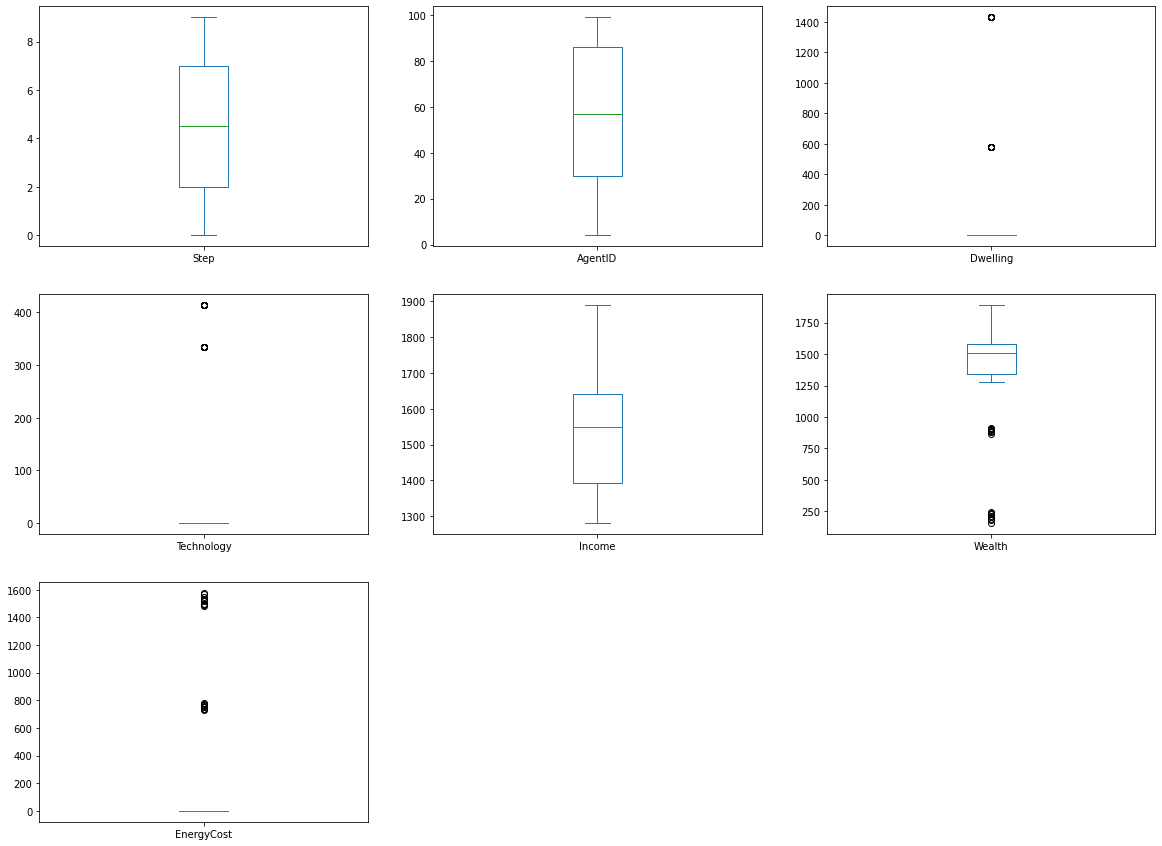

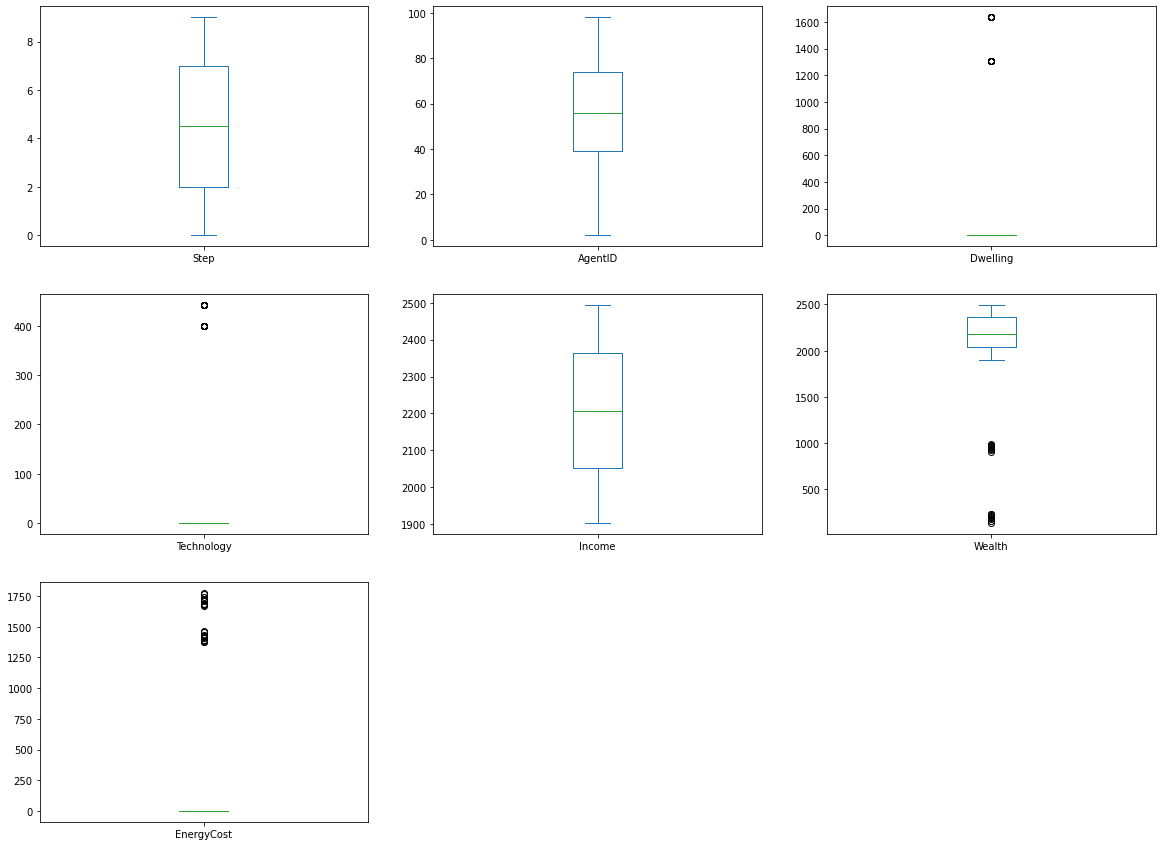

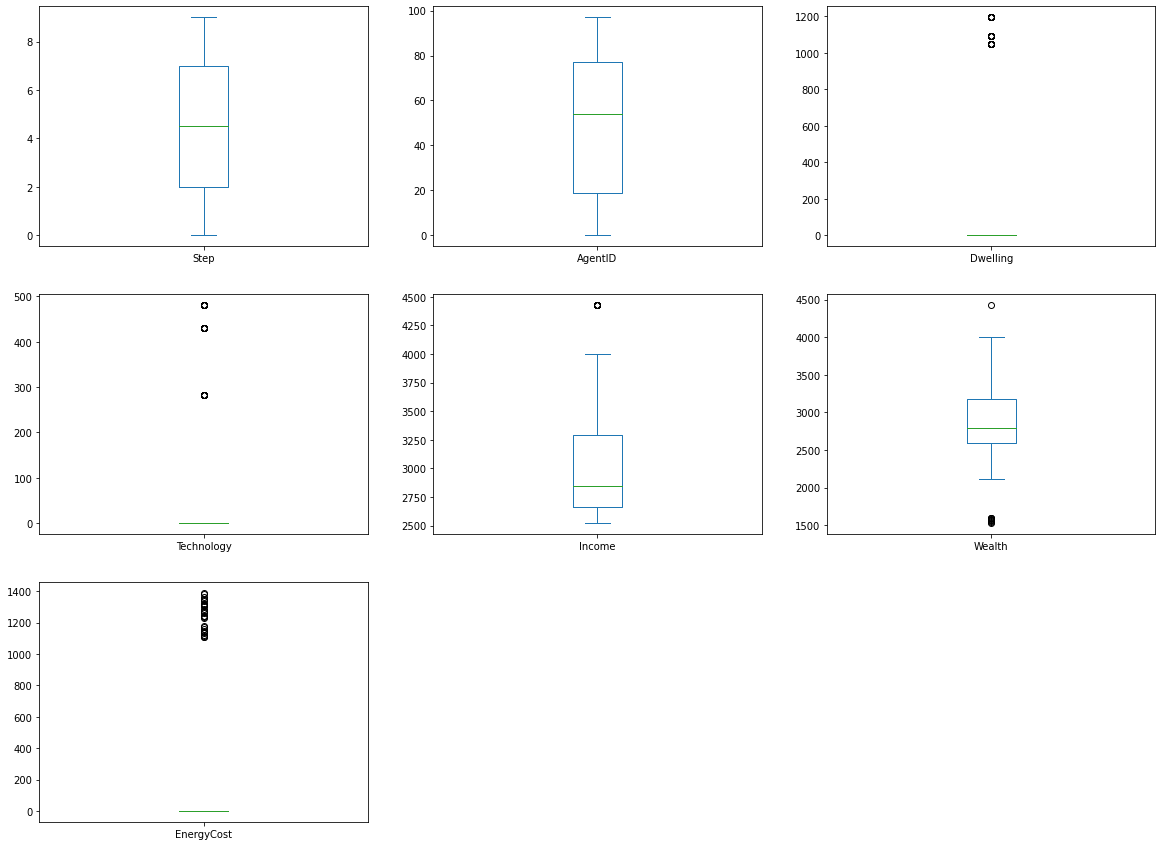

In [ ]:
# Get the quartiles of the "Income" column
agent_data['IncomeQuartile'] = pd.qcut(agent_data['Income'], 4, labels=False)

# Group by quartile
grouped = agent_data.groupby('IncomeQuartile')

# For each group, plot all the columns
for name, group in grouped:
    group.drop(columns=['IncomeQuartile']).plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(20,15))
    plt.title(f'Quartile {name+1}')
    plt.show()
